In [44]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns

import itertools
from itertools import cycle

from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc

from datetime import date, datetime, timedelta


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from torch import nn, optim
import torch.nn.functional as F
from arff2pandas import a2p

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [45]:
# https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf
# https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/
# https://github.com/BLarzalere/LSTM-Autoencoder-for-Anomaly-Detection
# https://github.com/curiousily/Getting-Things-Done-with-Pytorch

In [46]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

,RHR
2024-07-13,61.479138
2024-07-14,61.903125
2024-07-15,62.250794
2024-07-16,61.846516
2024-07-17,61.483994
...,...
2024-11-08,62.896629
2024-11-09,62.818185
2024-11-10,62.025778
2024-11-11,61.688097


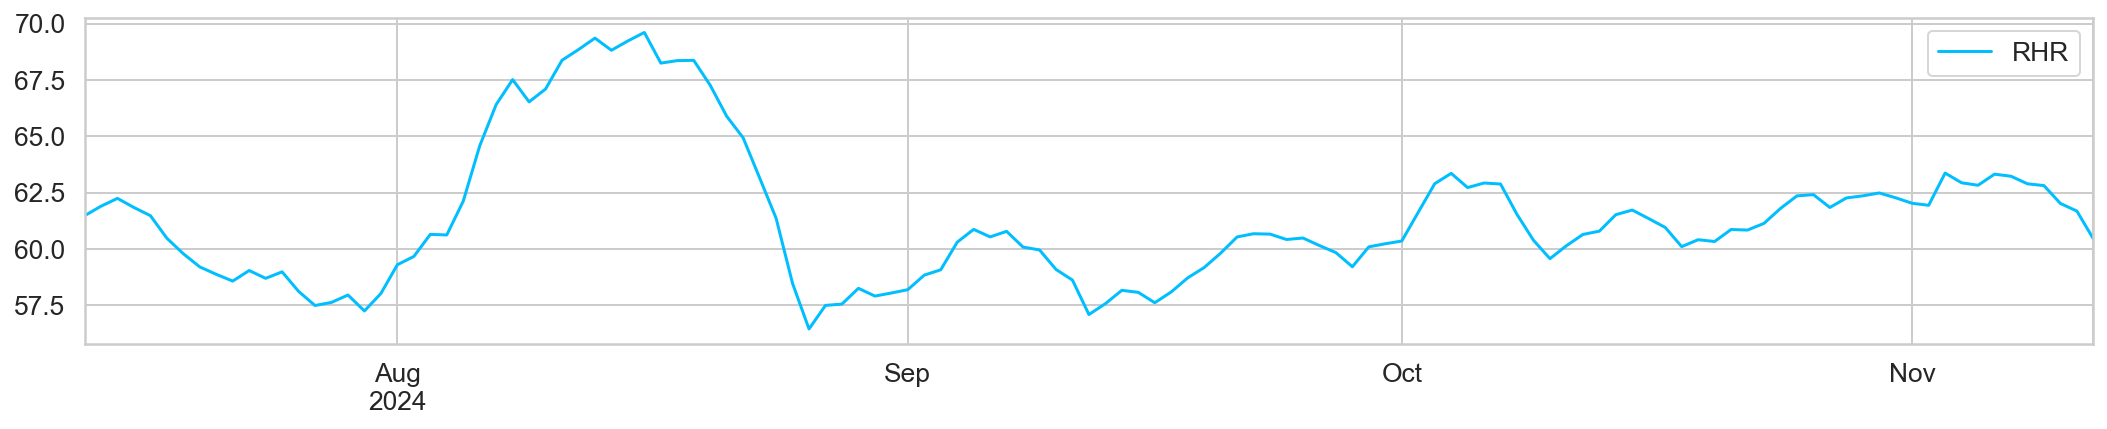

In [47]:
# symptom: 1-16-28
# diagnosis: NA

# read files  AJWW3IY
df_hr = pd.read_csv("COVID-19-Wearables/ASFODQR_hr.csv")
df_steps = pd.read_csv("COVID-19-Wearables/ASFODQR_steps.csv")

# resting heart rate
df_hr = df_hr.set_index('datetime')
df_hr.index.name = None
df_hr.index = pd.to_datetime(df_hr.index)

# steps data
df_steps = df_steps.set_index('datetime')
df_steps.index.name = None
df_steps.index = pd.to_datetime(df_steps.index)

# merge dataframes
#df_hr = df_hr.resample('1min').median()
#df_steps = df_steps.resample('1min').median()

df1 = pd.merge(df_hr, df_steps, left_index=True, right_index=True)
df1 = df1.resample('1min').mean()
df1 = df1.dropna()

        
# define RHR as the HR measurements recorded when there were zero steps taken during a rolling time window of the preceding 12 minutes (including the current minute)
df1['steps_window_12'] = df1['steps'].rolling(12).sum()
df1 = df1.loc[(df1['steps_window_12'] == 0)]

# This function takes resting heart rate data and applies moving averages to smooth the data and downsamples to one hour by taking the avegare values
df_nonas = df1.dropna()

df1_rom = df_nonas.rolling(400).mean()


# resample
df1_resmp = df1_rom.resample('24H').mean()
df2 = df1_resmp.drop(['steps'], axis=1)
df2 = df2.drop(['steps_window_12'], axis=1)
#df2 = df2.resample('24H').mean()
df2 = df2.dropna()
df2 = df2.rename(columns={"heartrate": "RHR"})

#df2.to_csv("./RHR_datasets/AKXN5ZZ_RHR.csv")

df2.plot(figsize=(18,3))
df2

In [48]:

train = df2[:20]
test = df2[20:]

# split train into train and validation datasets
# random sampling to avoid order
# split train into valid by random sampling and by not reproducing the same values

df4 = train.sample(frac=0.1, replace=False, random_state=1)
df5 = pd.merge(train, df4, how='outer', left_index=True, right_index=True, indicator=True)
df5_train = df5.query('_merge != "both"')
df5_train = df5_train.drop(['RHR_y', '_merge'], axis=1)
df5_train = df5_train.rename(columns={"RHR_x": "RHR"})

# valid
df5_valid = df5.query('_merge == "both"')
df5_valid = df5_valid.drop(['RHR_y', '_merge'], axis=1)
df5_valid = df5_valid.rename(columns={"RHR_x": "RHR"})

print(df5_train.shape, df5_valid.shape)


# standardize
scaler = StandardScaler().fit(train)
train[['RHR']] = scaler.fit_transform(train[['RHR']])
test[['RHR']] = scaler.transform(test[['RHR']])
df5_train[['RHR']] = scaler.transform(df5_train[['RHR']])
df5_valid[['RHR']] = scaler.transform(df5_valid[['RHR']])


# split test into test_normal and test_anomaly datasets
symptom_date = '2024-08-14'
symptom_date = pd.to_datetime(symptom_date)
symptom_date_before_7 = pd.to_datetime(symptom_date) + timedelta(days=-7)
symptom_date_after_21 = pd.to_datetime(symptom_date) + timedelta(days=21)
                     
test_anomaly = test[symptom_date_before_7:symptom_date_after_21]

test_normal = pd.merge(test,test_anomaly,  how='outer',  left_index=True, right_index=True)
# test_normal.plot()
test_normal = test_normal.loc[test_normal['RHR_y'].isnull()]
test_normal = test_normal.drop('RHR_y', axis=1)
test_normal = test_normal.rename({'RHR_x':'RHR'}, axis=1)


print(train.shape, test.shape, test_normal.shape, test_anomaly.shape)


(18, 1) (2, 1)
(20, 1) (103, 1) (74, 1) (29, 1)


/Users/gireeshbogu/miniconda2/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/gireeshbogu/miniconda2/lib/python3.6/site-packages/pandas/core/frame.py:3072: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/Users/gireeshbogu/miniconda2/lib/python3.6/site-packages/pandas/core/frame.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

## Creating LSTM input

In [49]:
# convert data with one feature innto tensor

def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [50]:
train_dataset, seq_len, n_features = create_dataset(df5_train)
val_dataset, _, _ = create_dataset(df5_valid)
test_dataset, _, _ = create_dataset(test)
test_normal_dataset, _, _ = create_dataset(test_normal)
test_anomaly_dataset, _, _ = create_dataset(test_anomaly)
# train_dataset.Size()

## Model

In [51]:

class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [52]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [53]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [54]:
model = RecurrentAutoencoder(seq_len, n_features, embedding_dim=128)
model = model.to(device)

# Training

In [55]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # default 0.01 LR
  criterion = nn.L1Loss(reduction='sum').to(device) # MAE = L1 Loss
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad() # using zero gradient.

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true) # measure error for the prediction

      loss.backward() # backpropagation
      optimizer.step() # optimizationn

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [56]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=60
)

Epoch 1: train loss 0.849151574075222 val loss 1.239908367395401
Epoch 2: train loss 0.81187514298492 val loss 1.235480636358261
Epoch 3: train loss 0.7644294719729159 val loss 1.0989185273647308
Epoch 4: train loss 0.48159287373224896 val loss 0.6865274310112
Epoch 5: train loss 0.3756712960700194 val loss 0.5051657259464264
Epoch 6: train loss 0.3220028289490276 val loss 0.3575606644153595
Epoch 7: train loss 0.415562919444508 val loss 0.23519432544708252
Epoch 8: train loss 0.14409871399402618 val loss 0.0170515775680542
Epoch 9: train loss 0.09107807609770033 val loss 0.18866771459579468
Epoch 10: train loss 0.14129450337754357 val loss 0.02633613348007202
Epoch 11: train loss 0.07691284517447154 val loss 0.13118335604667664
Epoch 12: train loss 0.08760239722000228 val loss 0.08669668436050415
Epoch 13: train loss 0.08274567085835668 val loss 0.2791798412799835
Epoch 14: train loss 0.19820865823162925 val loss 0.1939559280872345
Epoch 15: train loss 0.37652433580822414 val loss 0.4

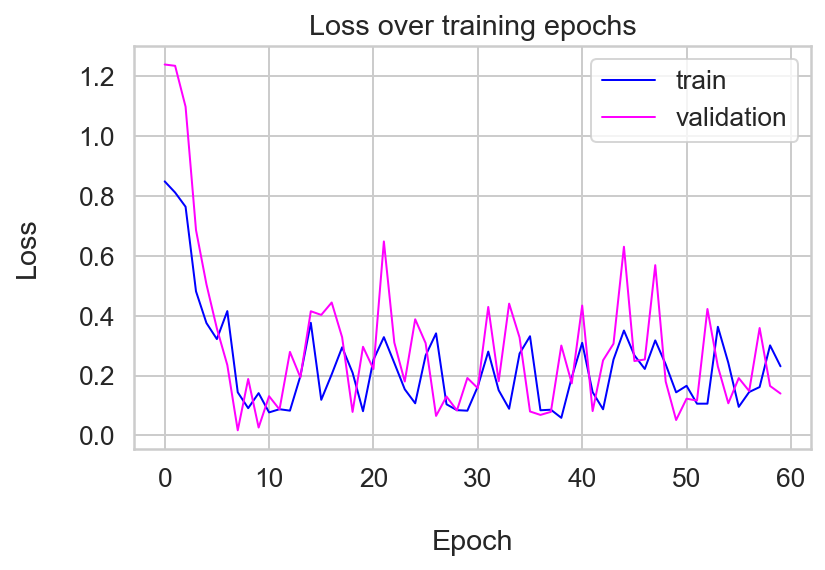

In [80]:
# the loss seems to be equal and it is an indication that our model is not overfitting.

ax = plt.figure(figsize=(6,4)).gca()

ax.plot(history['train'], lw=1, c='blue')
ax.plot(history['val'], lw=1, c='magenta')
plt.ylabel('Loss\n')
plt.xlabel('\nEpoch')
plt.legend(['train', 'validation'])
plt.tight_layout()
plt.title('Loss over training epochs')
plt.show();

In [58]:
## Save the model

MODEL_PATH = 'ASFODQR.pth'

torch.save(model, MODEL_PATH)

/Users/gireeshbogu/miniconda2/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RecurrentAutoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/gireeshbogu/miniconda2/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/gireeshbogu/miniconda2/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Choosing Threhold

In [59]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

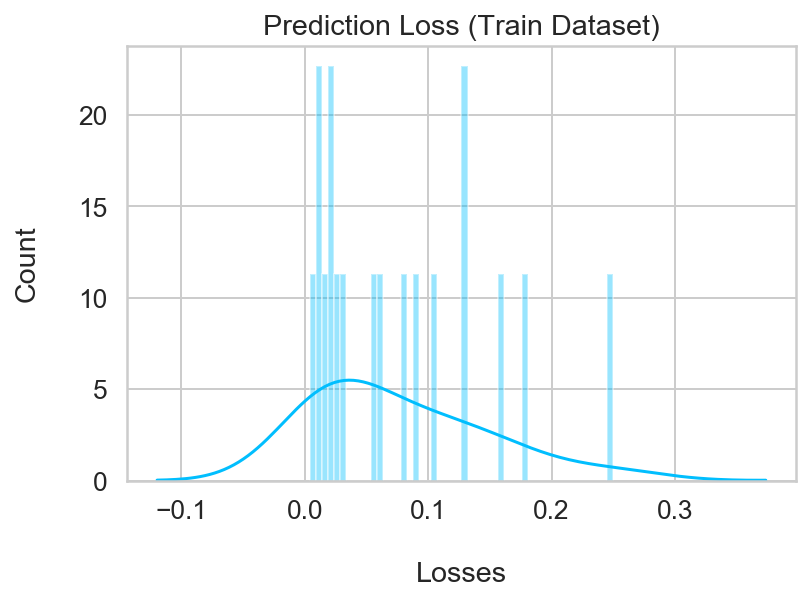

In [81]:
_, losses = predict(model, train_dataset)
ax = plt.figure(figsize=(6,4)).gca()
ax = sns.distplot(losses, bins=50, kde=True).set_title('Prediction Loss (Train Dataset)')
plt.xlabel('\nLosses')
# Set y-axis label
plt.ylabel('Count\n')
plt.show()

In [61]:
# Computing likelihood of anomaly

stats = pd.DataFrame(losses).describe()
print(stats)

mean = stats.filter(like='mean', axis=0)
mean = float(mean[0])


std = stats.filter(like='std', axis=0)
std = float(std[0])

THRESHOLD = mean + std + 0.5
THRESHOLD

               0
count  18.000000
mean    0.077534
std     0.069601
min     0.004395
25%     0.021826
50%     0.058837
75%     0.123632
max     0.249635


0.6471349512398399

Text(0.5, 1.0, 'Prediction Loss \n (Test Dataset)')

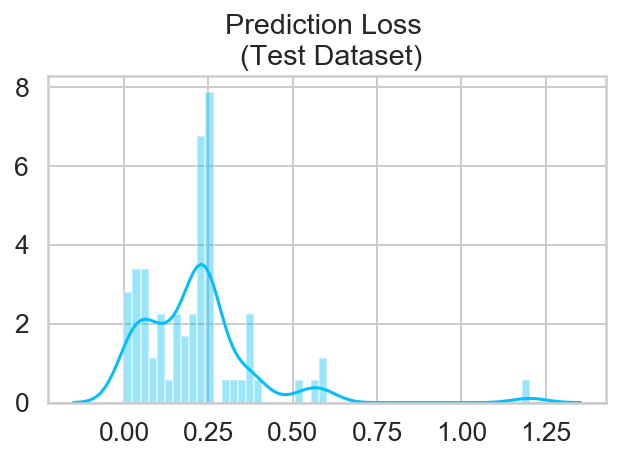

In [62]:
# evaluation
# TEST Normal

predictions, pred_losses = predict(model, test_normal_dataset)
plt.figure(figsize=(5,3))
sns.distplot(pred_losses, bins=50, kde=True).set_title('Prediction Loss \n (Test Dataset)')

Text(0.5, 1.0, 'Prediction Loss \n (Test Dataset)')

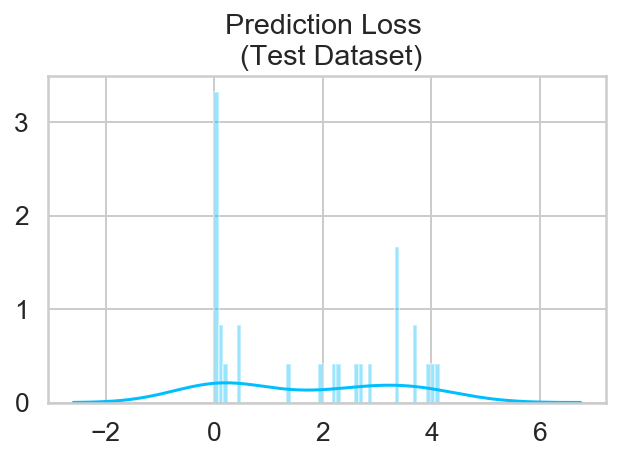

In [63]:
# evaluation
# TEST Anomaly

predictions, pred_losses = predict(model, test_anomaly_dataset)
plt.figure(figsize=(5,3))
sns.distplot(pred_losses, bins=50, kde=True).set_title('Prediction Loss \n (Test Dataset)')

Text(0.5, 1.0, 'Prediction Loss \n (Test Dataset)')

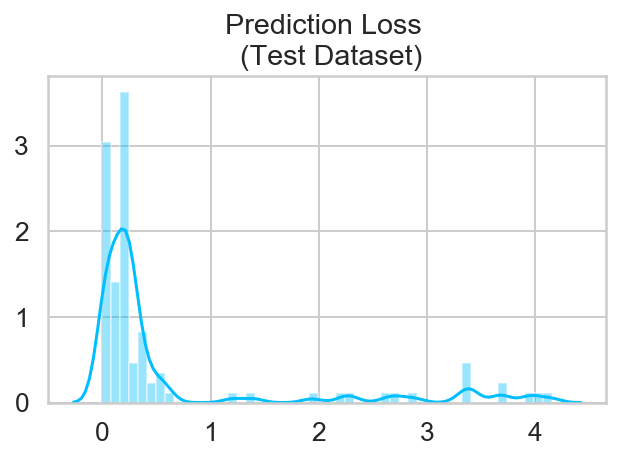

In [64]:
# evaluation
# TEST 

predictions, pred_losses = predict(model, test_dataset)
plt.figure(figsize=(5,3))
sns.distplot(pred_losses, bins=50, kde=True).set_title('Prediction Loss \n (Test Dataset)')

In [65]:
anomalies = sum(l < THRESHOLD for l in pred_losses)
print(f'Anomaly predictions: {anomalies}/{len(test_normal_dataset)}')

Anomaly predictions: 86/74


In [66]:
anomalies = sum(l < THRESHOLD for l in pred_losses)
print(f'Anomaly predictions: {anomalies}/{len(test_anomaly_dataset)}')

Anomaly predictions: 86/29


In [67]:
anomalies = sum(l < THRESHOLD for l in pred_losses)
print(f'Anomaly predictions: {anomalies}/{len(test_dataset)}')

Anomaly predictions: 86/103


# save anomaies and visualize

In [68]:

df3_test = test.reset_index()
df3_test = df3_test.rename(columns={'index':'datetime'})

test_score_df = df3_test
test_score_df['loss'] = pred_losses
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold

# save all anomalies
test_score_df = test_score_df.set_index("datetime")
anomalies = test_score_df[test_score_df.anomaly == True]

# save anomalies in positive direction
# anomalies = anomalies[anomalies.RHR >=0]

anomalies.to_csv('ASFODQR_anomalies.csv')
anomalies


,RHR,loss,threshold,anomaly
datetime,,,,
2024-08-06,3.292634,1.202180,0.647135,True
2024-08-07,4.464259,2.234536,0.647135,True
2024-08-08,5.171566,2.887460,0.647135,True
2024-08-09,4.541206,2.304770,0.647135,True
2024-08-10,4.904745,2.639365,0.647135,True
2024-08-11,5.719493,3.402218,0.647135,True
2024-08-12,6.022945,3.689777,0.647135,True
2024-08-13,6.347441,3.998853,0.647135,True
2024-08-14,6.003339,3.671153,0.647135,True


In [69]:
# mereg all datasets

# pd.merge(train_data, valid_data, test_data)

all_merged = pd.concat([df5_train, df5_valid, test])


In [70]:
all_merged

,RHR
2024-07-13,1.312907
2024-07-14,1.583814
2024-07-15,1.805957
2024-07-17,1.316010
2024-07-18,0.676968
...,...
2024-11-08,2.218614
2024-11-09,2.168493
2024-11-10,1.662183
2024-11-11,1.446422


Anomaly predictions: 106/123


,RHR,predictions,loss,threshold,anomaly
datetime,,,,,
2024-08-06,3.292634,2.090455,1.202180,0.647135,True
2024-08-07,4.464259,2.229722,2.234536,0.647135,True
2024-08-08,5.171566,2.284107,2.887460,0.647135,True
2024-08-09,4.541206,2.236436,2.304770,0.647135,True
2024-08-10,4.904745,2.265380,2.639365,0.647135,True
2024-08-11,5.719493,2.317275,3.402218,0.647135,True
2024-08-12,6.022945,2.333168,3.689777,0.647135,True
2024-08-13,6.347441,2.348588,3.998853,0.647135,True
2024-08-14,6.003339,2.332187,3.671153,0.647135,True


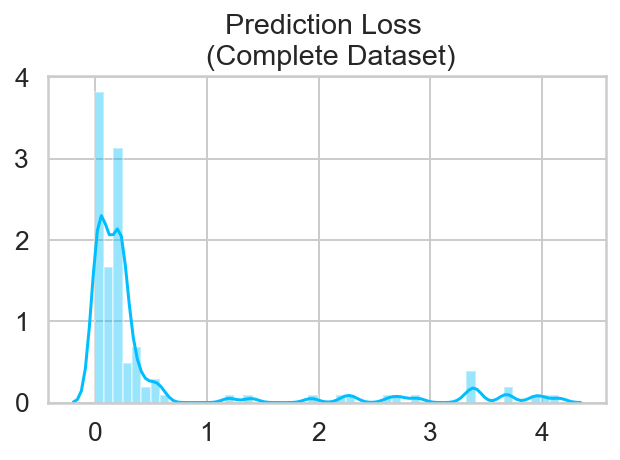

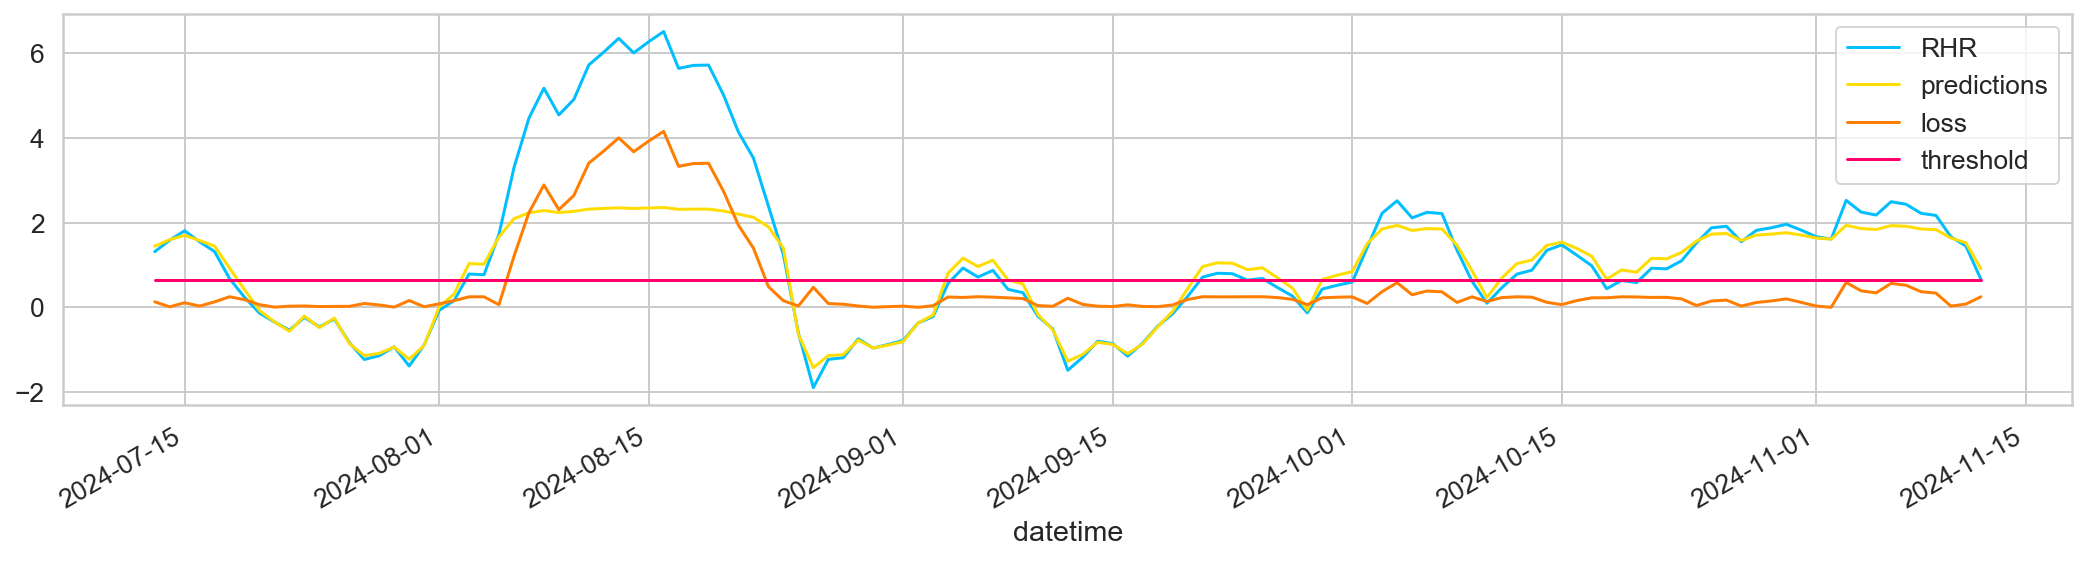

In [71]:
## Evaluatinng using the complete dataset



all_dataset, _, _ = create_dataset(all_merged)

predictions, pred_losses = predict(model, all_dataset)
plt.figure(figsize=(5,3))
sns.distplot(pred_losses, bins=50, kde=True).set_title('Prediction Loss \n (Complete Dataset)')

anomalies = sum(l < THRESHOLD for l in pred_losses)
print(f'Anomaly predictions: {anomalies}/{len(all_dataset)}')

df3_all = all_merged.reset_index()
df3_all = df3_all.rename(columns={'index':'datetime'})

all_score_df = df3_all
all_score_df['predictions'] = predictions
all_score_df['loss'] = pred_losses
all_score_df['threshold'] = THRESHOLD
all_score_df['anomaly'] = all_score_df.loss > all_score_df.threshold
all_score_df['predictions'] = all_score_df['predictions'].str[0]
all_score_df = all_score_df.set_index("datetime")
all_score_df.plot(figsize=(18,4))
all_score_df[(all_score_df.anomaly == True) ]

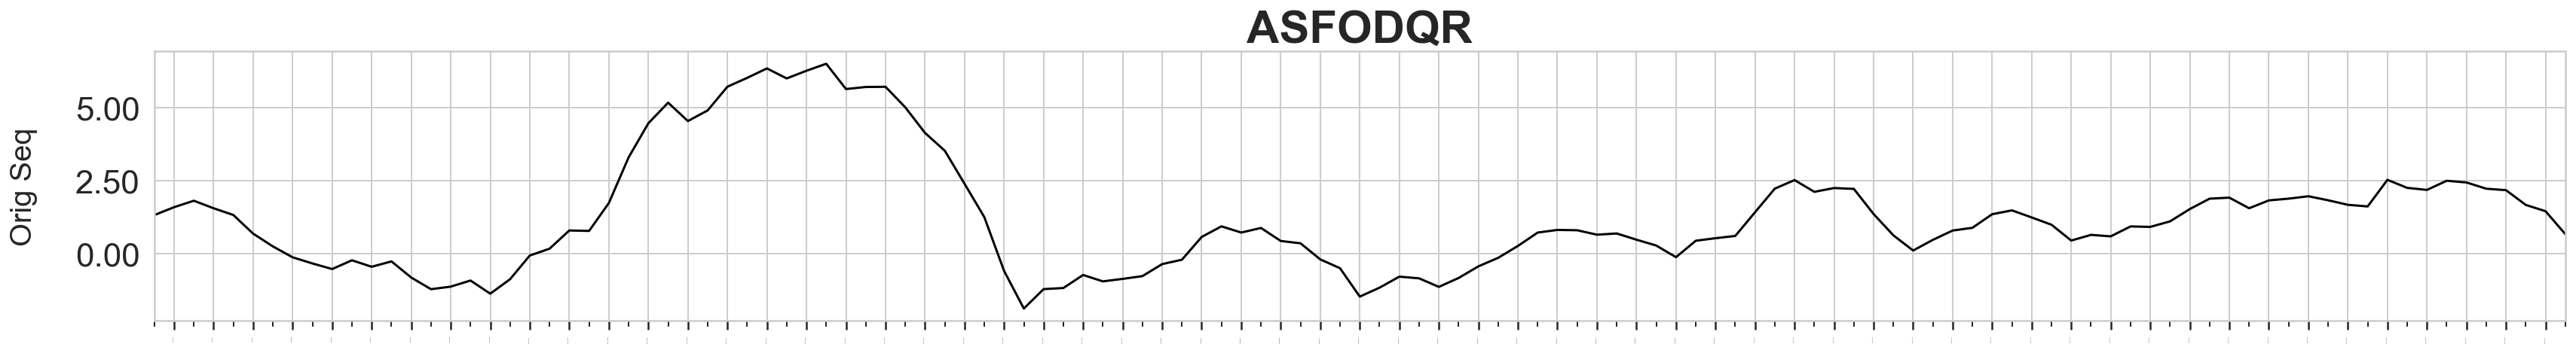

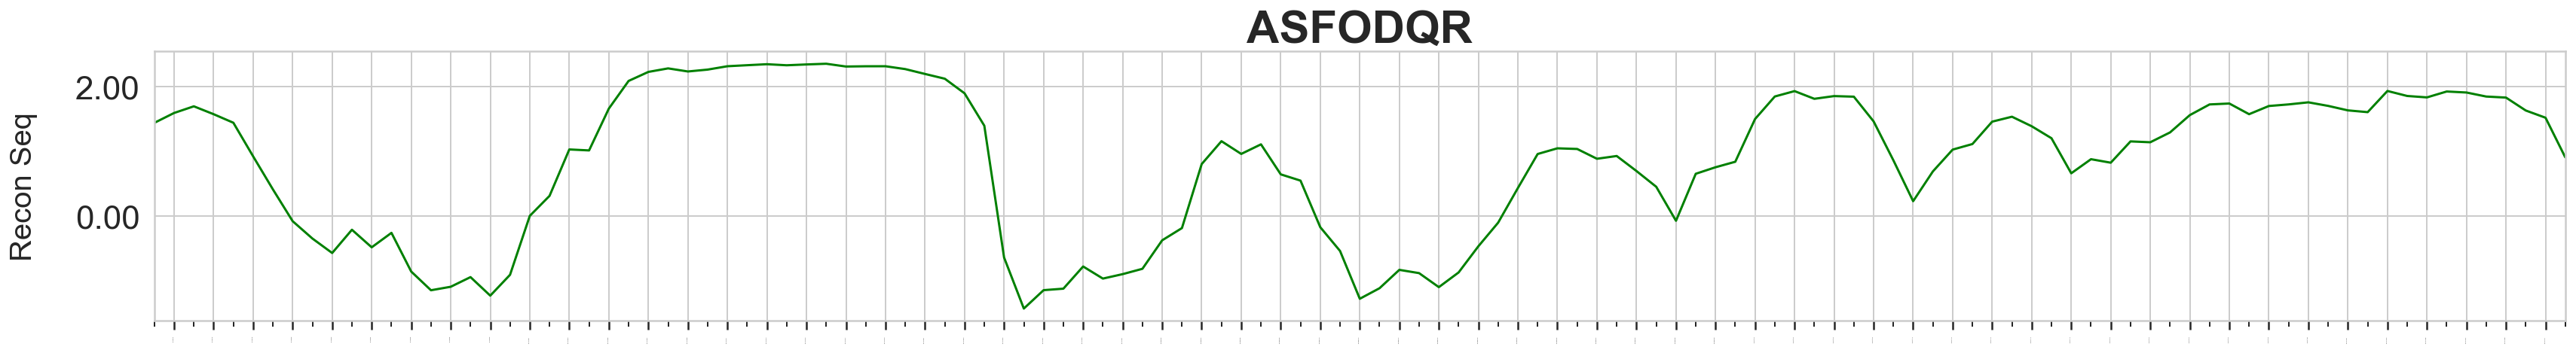

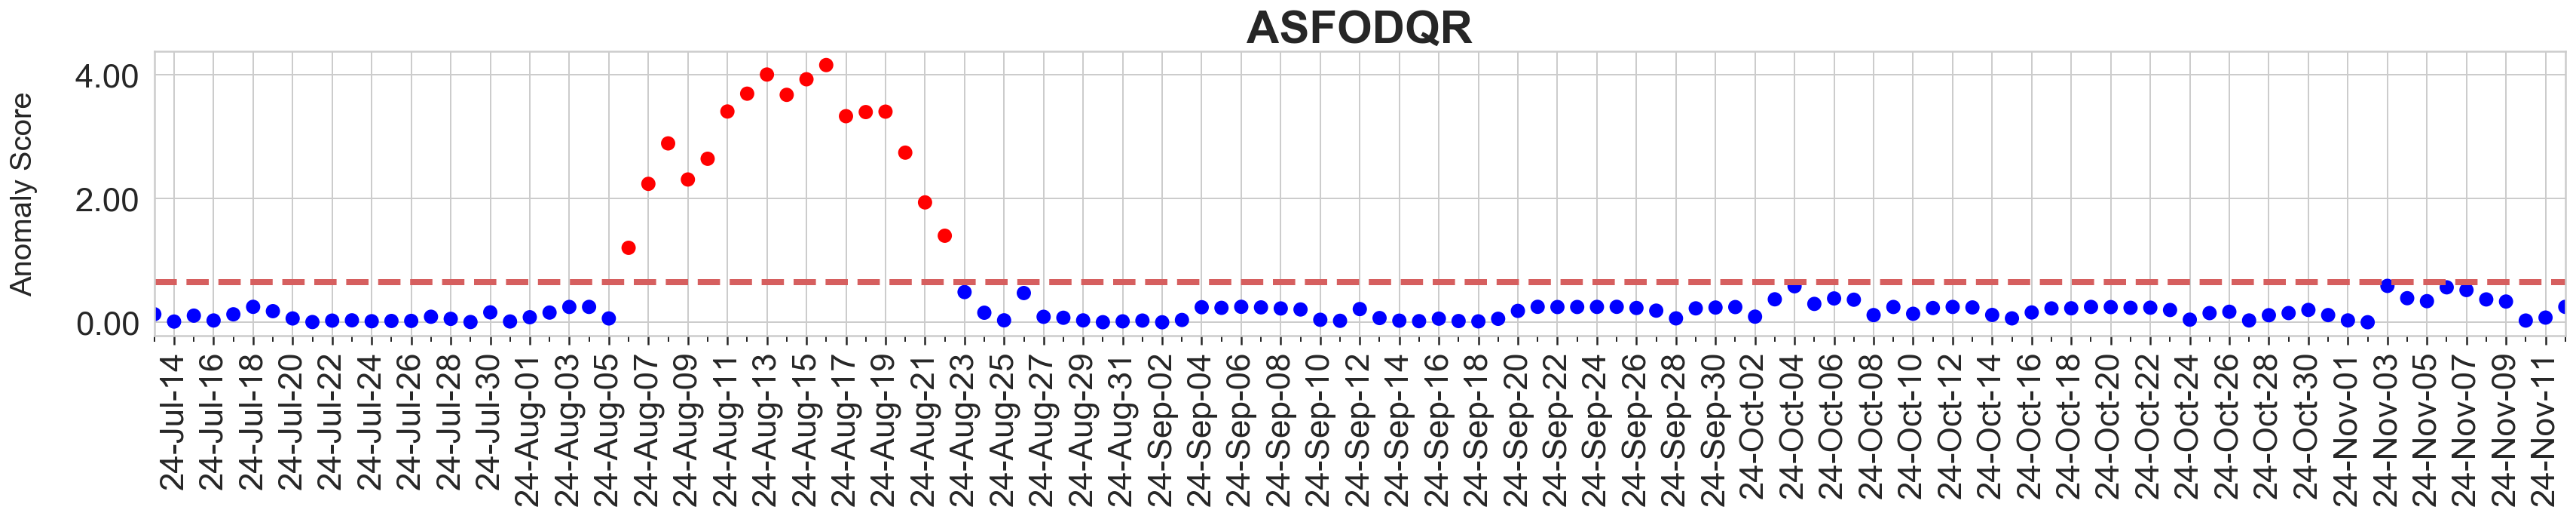

In [72]:
# plot original data

ax1 = all_score_df['RHR'].plot(figsize=(24,3.5), color="black", rot=90)
ax1.set_xlim(all_score_df.index[0], all_score_df.index[-1]) 
ax1.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%y-%b-%d'))
ax1.set_ylabel('Orig Seq\n', fontsize = 20) # Y label
ax1.set_xlabel('', fontsize = 0) # X label
ax1.tick_params(axis='both', which='major', labelsize=22)
ax1.set_xlabel('', fontsize = 0) # X label
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.set_title('ASFODQR',fontweight="bold", size=30) # Title
plt.xticks(fontsize=0, rotation=90)
plt.tick_params(axis='both',which='both',bottom=True, top=False, labelbottom=True)
plt.tight_layout()
plt.savefig('ASFODQR_all_original_seq.pdf', bbox_inches='tight')  
plt.show()

# plot reconstructed data
ax2 = all_score_df['predictions'].plot(figsize=(24,3.5), color="green", rot=90)
ax2.set_xlim(all_score_df.index[0], all_score_df.index[-1])  
ax2.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%y-%b-%d'))
ax2.set_ylabel('Recon Seq\n', fontsize = 20) # Y label
ax2.set_xlabel('', fontsize = 0) # X label
ax2.tick_params(axis='both', which='major', labelsize=22)
ax2.set_xlabel('', fontsize = 0) # X label
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.set_title('ASFODQR',fontweight="bold", size=30) # Title
plt.xticks(fontsize=0, rotation=90)
plt.tick_params(axis='both',which='both',bottom=True, top=False, labelbottom=True)
plt.tight_layout()
plt.savefig('ASFODQR_all_reconstructed_seq.pdf', bbox_inches='tight')  
plt.show()

# plot anomaly scores

all_score_df1 = all_score_df.reset_index()

ax3 = all_score_df1.plot.scatter(x='datetime',y='loss', figsize=(24,5),  rot=90,
                                marker='o', lw=5,
                                c=['red' if i== True else 'blue'  for i in all_score_df1['anomaly']])




ax3.set_xlim(all_score_df1['datetime'].iloc[0], all_score_df1['datetime'].iloc[-1]) 
ax3.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%y-%b-%d'))
ax3.set_ylabel('Anomaly Score\n', fontsize = 20) # Y label
ax3.set_xlabel('', fontsize = 0) # X label
ax3.tick_params(axis='both', which='major', labelsize=22)
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax3.set_title('ASFODQR',fontweight="bold", size=30) # Title
plt.axhline(y=THRESHOLD, color='r', linestyle='--', lw=4)
plt.tick_params(axis='both',which='both',bottom=True, top=False, labelbottom=True) 
plt.tight_layout()

plt.savefig('ASFODQR_all_anomaly_scores.pdf', bbox_inches='tight')  
plt.show()



## Metrics

In [73]:
# True positives (TP) are the number of anomalous days that are correctly identified as anomalous,
# False negatives (FN) are the no.of anomalous days that are incorrectly identified as normal.


#7-21 window (True preds are TPs and False are TNs)
all_score_df1 = all_score_df[['anomaly', 'predictions']]
test_anomaly_df1 = all_score_df1[symptom_date_before_7:symptom_date_after_21]
test_anomaly_df1 = test_anomaly_df1.groupby(['anomaly']).count()
test_anomaly_df1 = test_anomaly_df1.reset_index()

test_anomaly_df2 = test_anomaly_df1[test_anomaly_df1['anomaly'] == True]
TP = int(test_anomaly_df2['predictions'].values) if len(test_anomaly_df2)>0 else 0
print("TP:", TP)

test_anomaly_df3 = test_anomaly_df1[test_anomaly_df1['anomaly'] == False]
FN = int(test_anomaly_df3['predictions'].values) if len(test_anomaly_df3)>0 else 0
print("FN:", FN)

# True negative (TN) are the number of normal days that are correctly identified as normal
# False positives (FP) are the no.of normal days that are incorrectly identified as anomalous. 

#7: window (False=1)
test_normal_df1 = pd.merge(test_normal, all_score_df,  how='outer',  left_index=True, right_index=True)

test_normal_df1 = test_normal_df1.loc[test_normal_df1['RHR_x'].notnull()]
test_normal_df1 = test_normal_df1.drop({'RHR_x'},  axis=1)
test_normal_df1 = test_normal_df1.rename({'RHR_y':'RHR'}, axis=1)

test_normal_df1 = test_normal_df1.groupby(['anomaly']).count()
test_normal_df1 = test_normal_df1.reset_index()

test_normal_df2 = test_normal_df1[test_normal_df1['anomaly'] == False]
TN = int(test_normal_df2['predictions'].values) if len(test_normal_df2)>0 else 0
print("TN:", TN)

test_normal_df3 = test_normal_df1[test_normal_df1['anomaly'] == True]
FP = int(test_normal_df3['predictions'].values) if len(test_normal_df3)>0 else 0

print("FP:", FP)

TP: 16
FN: 13
TN: 73
FP: 1


In [74]:
# True positives (TP) are the number of anomalous days that are correctly identified as anomalous,
# False negatives (FN) are the no.of anomalous days that are incorrectly identified as normal.
# True negative (TN) are the number of normal days that are correctly identified as normal
# False positives (FP) are the no.of normal days that are incorrectly identified as anomalous. 

In [75]:
def metrics(tp, fp, tn, fn):
    sensitivity = tp / (tp+fn),
    specificity = tn / (tn+fp),
    precision = tp / (tp+fp),
    recall = tn / (tn+fn),
    return sensitivity, specificity, precision, recall
    

metrics_tuple = metrics(TP, FP, TN, FN)

metrics_list = list(itertools.chain.from_iterable(metrics_tuple))
metrics_df = pd.DataFrame([metrics_list])
metrics_df.columns =['Sensitivity','Specificity','Precision', 'Recall']
metrics_df.rename({0: 'ASFODQR'}, axis='index')
metrics_df.index = ['ASFODQR']
metrics_df

,Sensitivity,Specificity,Precision,Recall
ASFODQR,0.551724,0.986486,0.941176,0.848837


In [76]:
def metrics(tp, fp, tn, fn):
    sensitivity = tp / (tp+fn),
    specificity = tn / (tn+fp),
    precision = tp / (tp+fp),
    recall = tn / (tn+fn),
    return sensitivity, specificity, precision, recall
    

sensitivity, specificity, precision, recall= metrics(TP, FP, TN, FN)

metrics_list = (TP, FP, TN, FN, sensitivity, specificity, precision, recall)

metrics_df = pd.DataFrame([metrics_list])
metrics_df.columns =['TP', 'FP', 'TN', 'FN', 'Sensitivity','Specificity','Precision', 'Recall']
metrics_df.rename({0:  'ASFODQR'}, axis='index')
metrics_df.index = [ 'ASFODQR']
metrics_df

,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall
ASFODQR,16,1,73,13,"(0.5517241379310345,)","(0.9864864864864865,)","(0.9411764705882353,)","(0.8488372093023255,)"


## ROC

In [77]:
def test_normal_types(anomaly):
    if anomaly['anomaly'] == True:
        return 1
    elif anomaly['anomaly'] == False:
        return 0
    else:
        return 'OTHER'


def test_anomaly_types(anomaly):
    if anomaly['anomaly'] == False:
        return 1
    elif anomaly['anomaly'] == True:
        return 0
    else:
        return 'OTHER'
  
all_score_df1 = all_score_df[['anomaly', 'predictions']]
test_anomaly_df1 = all_score_df1[symptom_date_before_7:symptom_date_after_21]

test_normal_df1 = pd.merge(test_normal, all_score_df,  how='outer',  left_index=True, right_index=True)
test_normal_df1 = test_normal_df1.loc[test_normal_df1['RHR_x'].notnull()]
test_normal_df1 = test_normal_df1.drop({'RHR_x'},  axis=1)
test_normal_df1 = test_normal_df1.rename({'RHR_y':'RHR'}, axis=1)


test_anomaly_df1['y_score'] = test_anomaly_df1.apply(test_anomaly_types, axis=1)
test_anomaly_df1['y_test'] = '1'

test_normal_df1['y_score'] = test_normal_df1.apply(test_normal_types, axis=1)
test_normal_df1['y_test'] = '0'

preds = pd.concat([test_anomaly_df1, test_normal_df1], axis=0)
preds1 = preds.drop(['anomaly', 'predictions', 'loss', 'threshold', 'RHR'], axis=1)
preds2 = preds1.reset_index()
preds2 = preds2.rename({'index':'datetime'}, axis=1)

preds2

/Users/gireeshbogu/miniconda2/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/gireeshbogu/miniconda2/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,datetime,y_score,y_test
0,2024-08-07,0,1
1,2024-08-08,0,1
2,2024-08-09,0,1
3,2024-08-10,0,1
4,2024-08-11,0,1
...,...,...,...
98,2024-11-08,0,0
99,2024-11-09,0,0
100,2024-11-10,0,0
101,2024-11-11,0,0


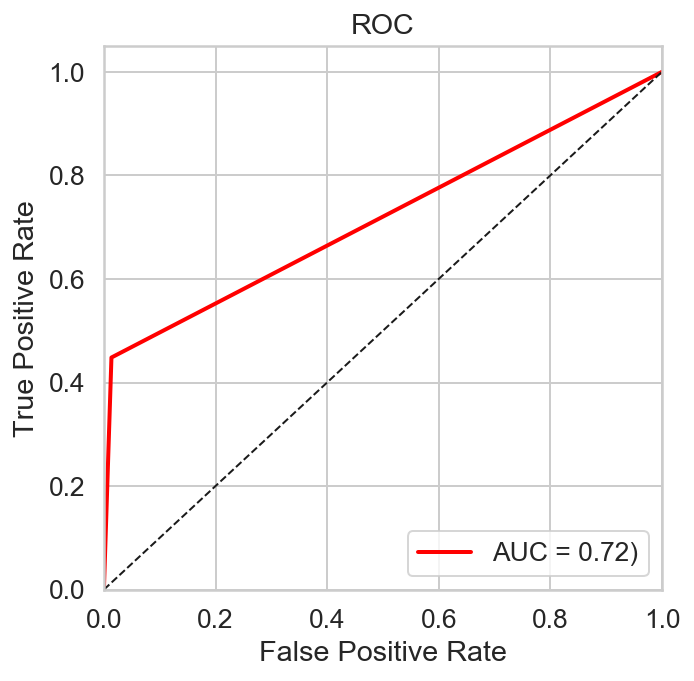

In [78]:
from sklearn.metrics import *
import pandas as pd
import matplotlib.pyplot as plt

y_test = np.array(preds2['y_test'], dtype=int)
y_score = np.array(preds2['y_score'], dtype=int)


plt.figure(figsize=(5,5))
fpr, tpr, thresholds = roc_curve(y_test, y_score)
auc1 = auc(fpr,tpr)

plt.plot(fpr, tpr,label='AUC = %0.2f)' % auc1, 
         #label="AUC Y2:{0}".format(auc1),
         color='red', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1) 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate') 
plt.title('ROC') 
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

# Pending

In [79]:
# Nov 3- Nov 30 - Read COVID papers and Write my paper for 30 min each every day.


# Nov 4 - Wed
# TP,FP,FN,TN calculations
# change LAAD code with new github code and see if there is any difference.
# add sleep data - experiment alone and together with RHR, activity and night time data only
# Read COVID and LSTM papers

# Nov 5 - Thu
# Read COVID and LSTM papers
# imputing. - smoothing -  add sleep data - experiment alone and together with RHR, activity and night time data only
# imputing and smoothing for steps and sleep data????
# no of epochs should be more?
# usingn first PCA instead of 3 vectors?
# using only night's data?



# laad_multi_sensor script, and night only option


# change the window for test_normal?

# write a brief summary about the experiments, you made today annd logic behind it. and update figures in Github. 
# And explaint he rationale behind why RHR is good measure but not sleep and steps for tracking an infection. 



# run all scripts on all datasets



# Nov 6 - Fri
# input should changed? can be obtained by taking a window of length L over a larger time-series.

# tune threshold using Sens and Spec - Max likelihood?
# Read COVID and LSTM papers

# Nov 7 - Sat
# # tune no.of epochs, LR, Hyper-parameter tuning
# Read COVID and LSTM papers

# Nov 8 - Sun
# add a classifier to the pipeline with COVID-neg dataset (use arash's)
# Read COVID and LSTM papers

# Nov 9 - Mon
# First draft and talk to Mike.



# COVER work - pao
# Animation for Github

# Am I doing these thse right? - consult a specialist or SO? and go over thee code and assumptions and results.
# practice explaining and writing how LSTM autoencoder works, pytorch code walk through, pros and cons, published work.
# validation datasets - 2 - I can try nat med if I can do this. If not Lancet DH.
# Finish writing, reviewing and submit paper - Nov 30

# online version???????

# does smoothing should be done before running lstm? - It's okay as long as it doesn;t introduce a look ahead.
# input format 5 min interval format identify hidden structures??




# new points int the paper:



# nighttime vs daytime data predictions
# single vs multi-sensor models
# scripps vs stanford's study results comparision
# Stat models vs DL model results comparision
# metrics based on viral load and symptom onset research. 


# main
--demonstrated sensitive detection of COVID-19 using smartwatch
- Can detect 4 days median before symptoms
- Built an alarming system for large scale rollout.

# drawbacks
- Not tested against COVID-negative and asymptomatic cohorts
- Alarms are not specific to COVID-19 alone
 
 

## Assumptions

####  Quer et.al., 
study assumptions - unknown method - classify individuals - use RHR, Steps and Sleep with symptoms -  pool all individuals and use a universal model

* 0 to -7 or -21 before symptom date = baseline
* 0 to +7 from and after the symptom date = test data

* opposite RHR findings


#### Mishra et.al., 
study assumptions - CuSum, GDE - classify hours - use RHR data - individual specific models/threholds - manual tuning

* 0 to -14 or +7 (from symptom date)   = anomaly signals in test data
* 0 to -21 or +7  (from diagnosis date) = anomaly signals in test data
* +21 before -14+7/-21+7 windows = baseline and  everythig else is test data


#### Natarajan et.al., 
study assumptions - CNN - classify days - use multi-sensor data -  pool all individuals and use a universal model
* -8 to -21 = negative
* -7 to 0 = discarded
* +1 to +7 = positive


#### Marinsek et.al., 
* opposite RHR findings



#### Hodge te.al., study findings based on RT-PCR

* -7 = pre-symptomatic
* +0 to 21 = symptomatic
* +7 to 28 = recovery


#### Bogu et.al., - classify days at individual level (LSTM-AE) and at population level (CNN) using multi-sensor data and automatic tuning. 

Data splits

Data is split into train and test
 - Days prior COVID-19 symptoms = Train
 - Days proximal COVID-19 symptoms = Test
     - Days proximal to COVID-19 symptoms excluding pre-symptomatic and recovery days = Test_normal
     - Days proximal to COVID-19 symptoms with only pre-symptomatic and symptomatic days = Test_anomaly

If on avaerage the dataset is 2 months long:
   - the train data will first 20 days and the later would be test assuming the symptom date is in the later month. 

   - Test data is further split into anomaly and normal
        - 7-0-21 = test_anomaly (14 days, 7-0 = pre-symptomatic, 0-21 = symptomatic)
        - < 7 | > 21 = test_normal ( ~26 days, < 7 = downstream of pre-symptomatic, > 21 = upstream of symtpomatic)


    If anomaly sequence prediction falls in 7-0-21 = TP
    True positives (TP) are the number of anomalous days that are correctly identified as anomalous.
    
    If anomaly sequence prediction falls out of 7-0-21 = FN
    False negatives (FN) are the no.of anomalous days that are incorrectly identified as normal.
    
    If normal sequence prediction falls in 7-0-21 = TN
    True negative (TN) are the number of normal days that are correctly identified as normal.
    
    If normal sequence prediction falls out of 7-0-21 = FP
    False positives (FP) are the no.of normal days that are incorrectly identified as anomalous. 
    

What about asymptomatic?? - Niall J. Lennon et.al.